In [1]:
import matplotlib.pyplot as plt
from os import listdir
import os
from os.path import isfile, join
import json
import pandas as pd
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(1.33*11.7,1.33*8.27)})

In [2]:
def listdirs(rootdir, dirs):
    #https://www.techiedelight.com/list-all-subdirectories-in-directory-python/
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d+'/')
            #print(d)
            listdirs(d, dirs)
    return dirs
rootdir = '../logfiles/'
dirs = []
dirs = listdirs(rootdir, dirs)

In [3]:
paths = [
    '../logfiles/baseline/',
    '../logfiles/experiments/re_pruning/',
    '../logfiles/experiments/gd_top_k_mc_ac_dk/',
    
    '../logfiles/ablation_study/alexnet_mixed/',
    '../logfiles/ablation_study/resnet_mixed/',
    
    '../logfiles/ablation_study/admm_intra/',
    '../logfiles/ablation_study/admm_retrain/',
    
    '../logfiles/ablation_study/gd_top_k/',
    '../logfiles/ablation_study/gd_top_k_mc/',
    '../logfiles/ablation_study/gd_top_k_mc_ac/',
    '../logfiles/ablation_study/gd_top_k_mc_ac_dk/',
    '../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_intra/',
    '../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_retrain/',
    
    '../logfiles/ablation_study/re_pruning/',
    '../logfiles/ablation_study/re_pruning_admm_retrain/',
    '../logfiles/ablation_study/re_pruning_admm_intra/',
    '../logfiles/ablation_study/re_pruning_ac/',
    '../logfiles/ablation_study/re_pruning_ac_admm_intra/',
    '../logfiles/ablation_study/re_pruning_ac_admm_retrain/',
    '../logfiles/ablation_study/re_pruning_gd_top_k_mc_ac_dk_admm_intra/',
    '../logfiles/ablation_study/re_pruning_gd_top_k_mc_ac_dk_admm_retrain/'
        ]

In [4]:
paths = dirs
logs = []
for path in paths:
    print(path, flush=True)
    fnames = [f for f in listdir(path) if isfile(join(path, f))]
    for fname in fnames:
        if 'json' in fname:
            with open(path+fname, 'r') as f:
                logs.append(json.load(f))
        

../logfiles/ablation_study/
../logfiles/ablation_study/admm_intra/
../logfiles/ablation_study/admm_retrain/
../logfiles/ablation_study/alexnet_mixed/
../logfiles/ablation_study/gd_top_k/
../logfiles/ablation_study/gd_top_k_mc/
../logfiles/ablation_study/gd_top_k_mc_ac/
../logfiles/ablation_study/gd_top_k_mc_ac_dk/
../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_intra/
../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_retrain/
../logfiles/ablation_study/resnet_mixed/
../logfiles/ablation_study/re_pruning/
../logfiles/ablation_study/re_pruning_ac/
../logfiles/ablation_study/re_pruning_ac_admm_intra/
../logfiles/ablation_study/re_pruning_ac_admm_retrain/
../logfiles/ablation_study/re_pruning_admm_intra/
../logfiles/ablation_study/re_pruning_admm_retrain/
../logfiles/ablation_study/re_pruning_gd_top_k_mc_ac_dk_admm_intra/
../logfiles/ablation_study/re_pruning_gd_top_k_mc_ac_dk_admm_retrain/
../logfiles/baseline/
../logfiles/experiments/
../logfiles/experiments/gd_top_k_mc_ac_dk/
../logfi

In [13]:
def single_eval(dataset, model, name, specs_to_print, results_to_print, plt_corr = True):
    pd_dict = {}
    for log in logs:
        if (log['METADATA']['EXPERIMENT']['dataset'] == dataset and 
            log['METADATA']['EXPERIMENT']['name'] == name and
            log['METADATA']['EXPERIMENT']['model'] == model):
            #if log['LOGDATA']['test_accuracy'][-1] <= 0.1:
            #    continue
            outstring = model.upper() + ' ' + dataset.upper() + ' ' + name.upper() + '\n'
            for key in specs_to_print:
                section = None
                if key in log['METADATA']['SPECIFICATION']:
                    section = 'SPECIFICATION'
                if key in log['METADATA']['EXPERIMENT']:
                    section = 'EXPERIMENT'
                
                outstring += key + ':' + log['METADATA'][section][key] + '\n'
                if key not in pd_dict:
                    pd_dict[key] = []
                pd_dict[key].append(float(log['METADATA'][section][key]))
            #outstring += '\n'
            for key in results_to_print:
                if type(log['LOGDATA'][key]) == type([]):
                    outstring += key + ':' + str(round(log['LOGDATA'][key][-1], 2)) + '\n'
                    if key not in pd_dict:
                        pd_dict[key] = []
                    pd_dict[key].append(log['LOGDATA'][key][-1])
                else:
                    outstring += key + ':' + str(round(log['LOGDATA'][key], 2)) + '\n'
                    if key not in pd_dict:
                        pd_dict[key] = []
                    pd_dict[key].append(log['LOGDATA'][key])
                    
            #    if type(log['LOGDATA'][key]) == type([]):
            #        plt.plot(log['LOGDATA'][key], label=key)
            #plt.title(model.upper() + ' ' + dataset.upper() + ' ' + name.upper())
            #plt.legend()
            #plt.show()
            outstring+='\n'
            print(outstring)
                
    if plt_corr:
        pd_df = pd.DataFrame(pd_dict)
        if len(pd_df) > 0:
            pd_df = pd_df.loc[:, (pd_df != pd_df.iloc[0]).any()] #drop const cols
            sns.heatmap(pd_df.corr(), cbar=True, annot=True, cmap='RdBu')
            plt.title(model.upper() + ' ' + dataset.upper() + ' ' + name.upper())
            plt.xticks(rotation=45) 
            plt.show()
            
def cross_eval(best_results, datasets, models, name, specs_to_print, results_to_print, plt_corr = True):
    pd_dict = {}
    res_dict = {}
    best_config = {}
    for model in models:
        for dataset in datasets:
            if model not in res_dict:
                res_dict[model] = {}
            if dataset not in res_dict[model]:
                res_dict[model][dataset] = {}
            if model not in best_config:
                best_config[model] = {}
            if dataset not in best_config[model]:
                best_config[model][dataset] = {}
            res_dict[model][dataset]['test_accuracy'] = 0.0
            res_dict[model][dataset]['total_su'] = 1.0
            res_dict[model][dataset]['current_su_fwd'] = 1.0
            res_dict[model][dataset]['current_sparsity'] = 0.0
            
            for log in logs:
                if (log['METADATA']['EXPERIMENT']['dataset'] == dataset and 
                    log['METADATA']['EXPERIMENT']['name'] == name and
                    log['METADATA']['EXPERIMENT']['model'] == model):
                    outstring = model.upper() + ' ' + dataset.upper() + ' ' + name.upper() + '\n'
                    if log['LOGDATA']['test_accuracy'][-1] <= 0.1:
                        continue
                    if log['LOGDATA']['test_accuracy'][-1] > 1:
                        log['LOGDATA']['test_accuracy'] = [x * 1e-2 for x in log['LOGDATA']['test_accuracy']]
                        
                    #TODO = selectable . in rounding
                    if round(res_dict[model][dataset]['test_accuracy'],2) < round(log['LOGDATA']['test_accuracy'][-1],2):
                        res_dict[model][dataset]['test_accuracy'] = log['LOGDATA']['test_accuracy'][-1]
                        if name != 'baseline':
                            res_dict[model][dataset]['current_su_fwd'] = log['LOGDATA']['current_su_fwd'][-1]
                            res_dict[model][dataset]['total_su'] = log['LOGDATA']['total_su'][-1]
                            res_dict[model][dataset]['current_sparsity'] = log['LOGDATA']['current_sparsity'][-1]
                            best_config[model][dataset]['METADATA'] = log['METADATA']
                    if round(res_dict[model][dataset]['test_accuracy'],2) == round(log['LOGDATA']['test_accuracy'][-1],2):
                        if name != 'baseline':
                            if round(res_dict[model][dataset]['total_su'],2) < round(log['LOGDATA']['total_su'][-1],2):
                                res_dict[model][dataset]['current_su_fwd'] = log['LOGDATA']['current_su_fwd'][-1]
                                res_dict[model][dataset]['test_accuracy'] = log['LOGDATA']['test_accuracy'][-1]
                                res_dict[model][dataset]['total_su'] = log['LOGDATA']['total_su'][-1]
                                res_dict[model][dataset]['current_sparsity'] = log['LOGDATA']['current_sparsity'][-1]
                                best_config[model][dataset]['METADATA'] = log['METADATA']
                    
                    for key in specs_to_print:
                        section = None
                        if key in log['METADATA']['SPECIFICATION']:
                            section = 'SPECIFICATION'
                        if key in log['METADATA']['EXPERIMENT']:
                            section = 'EXPERIMENT'

                        outstring += key + ':' + log['METADATA'][section][key] + '\n'
                        if key not in pd_dict:
                            pd_dict[key] = []
                        pd_dict[key].append(float(log['METADATA'][section][key]))
                    #outstring += '\n'
                    for key in results_to_print:
                        if type(log['LOGDATA'][key]) == type([]):
                            outstring += key + ':' + str(round(log['LOGDATA'][key][-1], 2)) + '\n'
                            if key not in pd_dict:
                                pd_dict[key] = []
                            pd_dict[key].append(log['LOGDATA'][key][-1])
                        else:
                            outstring += key + ':' + str(round(log['LOGDATA'][key], 2)) + '\n'
                            if key not in pd_dict:
                                pd_dict[key] = []
                            pd_dict[key].append(log['LOGDATA'][key])

                    #    if type(log['LOGDATA'][key]) == type([]):
                    #        plt.plot(log['LOGDATA'][key], label=key)
                    #plt.title(model.upper() + ' ' + dataset.upper() + ' ' + name.upper())
                    #plt.legend()
                    #plt.show()
                    outstring+='\n'
                    #print(outstring)
    for model in res_dict:
        for dataset in res_dict[model]:
            if res_dict[model][dataset]['test_accuracy'] > 0.0:
                #print(res_dict[model][dataset].keys())
                print('EXP.: {}, MODEL: {}, DATA: {}'.format(name, model, dataset))
                print('ACC.: {}, TRAIN SU: {}, INF. SU: {}, SP.: {}'.format(
                      round(res_dict[model][dataset]['test_accuracy'],2),
                      round(res_dict[model][dataset]['total_su'],2),
                      round(res_dict[model][dataset]['current_su_fwd'],2),
                      round(res_dict[model][dataset]['current_sparsity'],2)))
                #print(best_config[model][dataset])
    print('\n\n')
    if plt_corr:
        pd_df = pd.DataFrame(pd_dict)
        if len(pd_df) > 0:
            corr = pd_df.corr()
            mask = np.zeros_like(corr, dtype=np.bool)
            mask[np.triu_indices_from(mask)] = True
            pd_df = pd_df.loc[:, (pd_df != pd_df.iloc[0]).any()] #drop const cols
            sns.heatmap(corr, mask=mask, cbar=True, square=True, annot=True, cmap='RdBu')
            plt.title(name.upper())
            plt.xticks(rotation=90) 
            plt.show()
            
    best_results[name] = {'cfg' : best_config, 'res': res_dict}

EXP.: baseline, MODEL: resnet18, DATA: cifar10
ACC.: 0.75, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: resnet18, DATA: cifar100
ACC.: 0.43, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: resnet20, DATA: cifar10
ACC.: 0.8, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: resnet32, DATA: cifar10
ACC.: 0.81, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: resnet32, DATA: cifar100
ACC.: 0.47, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: resnet50, DATA: cifar10
ACC.: 0.74, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.74, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: alexnet_s, DATA: cifar100
ACC.: 0.41, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: mobilenet_v2, DATA: cifar10
ACC.: 0.77, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: mobi

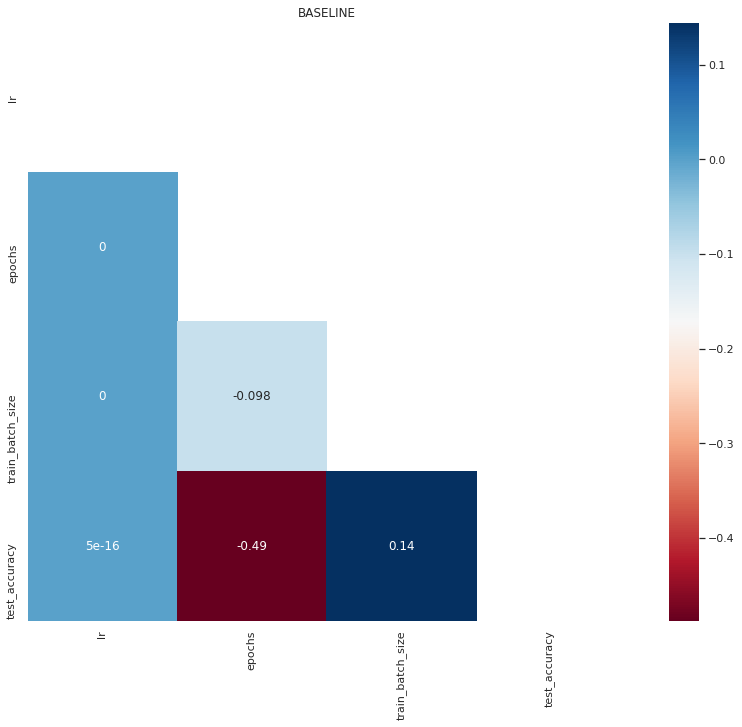

EXP.: admm_intra, MODEL: resnet18, DATA: cifar10
ACC.: 0.75, TRAIN SU: 2.48, INF. SU: 1.86, SP.: 0.71
EXP.: admm_intra, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.72, TRAIN SU: 2.17, INF. SU: 1.86, SP.: 0.98
EXP.: admm_intra, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 2.03, INF. SU: 12.01, SP.: 0.99





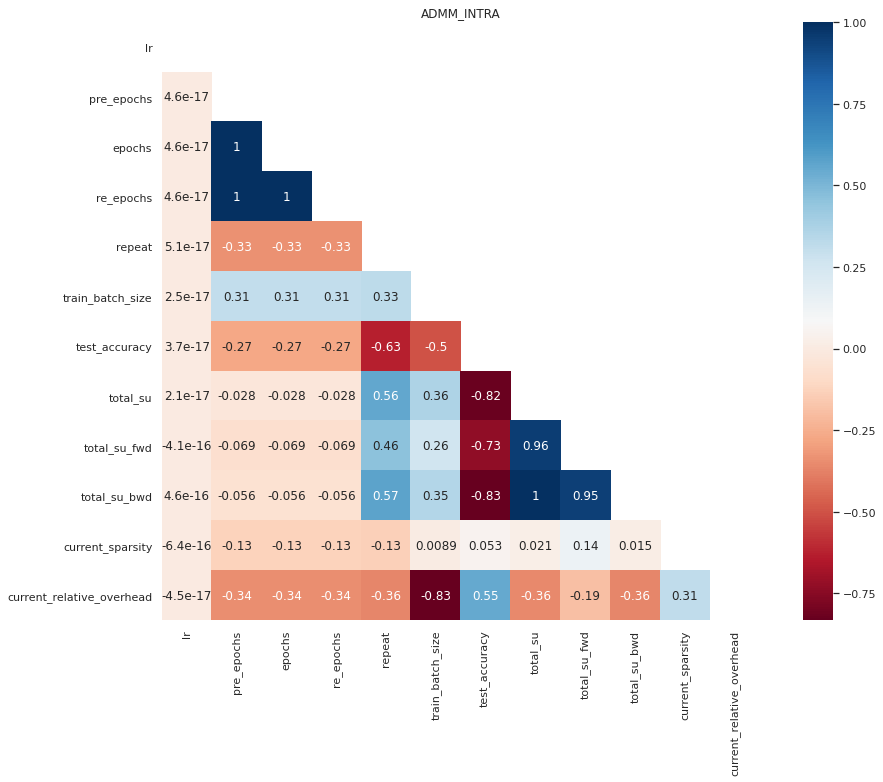

EXP.: admm_retrain, MODEL: resnet18, DATA: cifar10
ACC.: 0.7, TRAIN SU: 1.32, INF. SU: 1.86, SP.: 0.71
EXP.: admm_retrain, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.7, TRAIN SU: 1.53, INF. SU: 1.86, SP.: 0.98
EXP.: admm_retrain, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 1.24, INF. SU: 12.01, SP.: 0.99





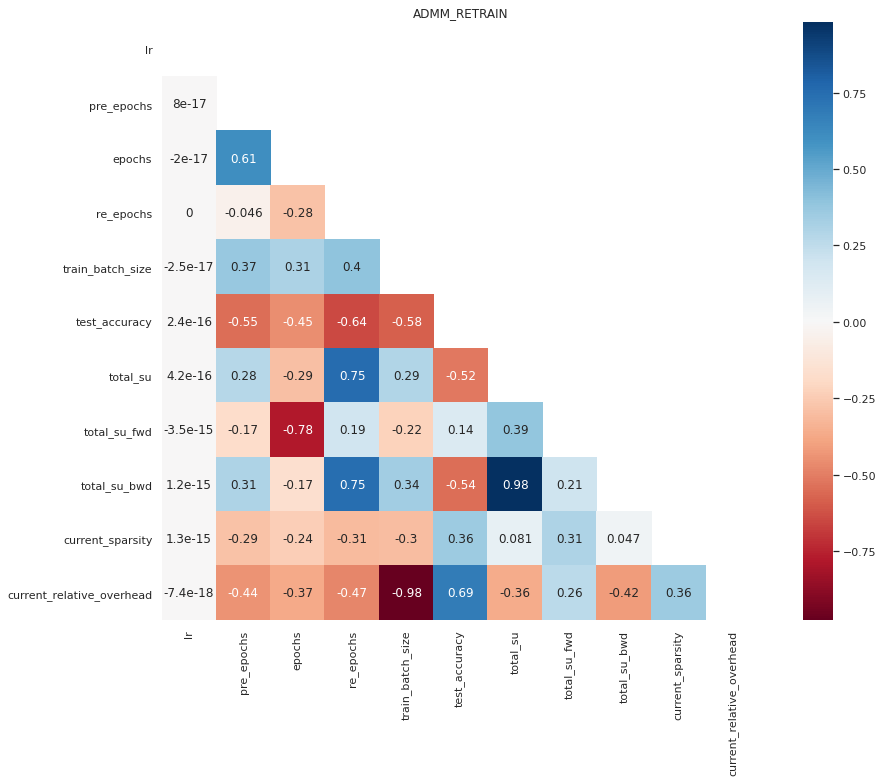

EXP.: gd_top_k, MODEL: resnet18, DATA: cifar10
ACC.: 0.76, TRAIN SU: 1.24, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.73, TRAIN SU: 1.48, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 2.07, INF. SU: 1.0, SP.: 0.0





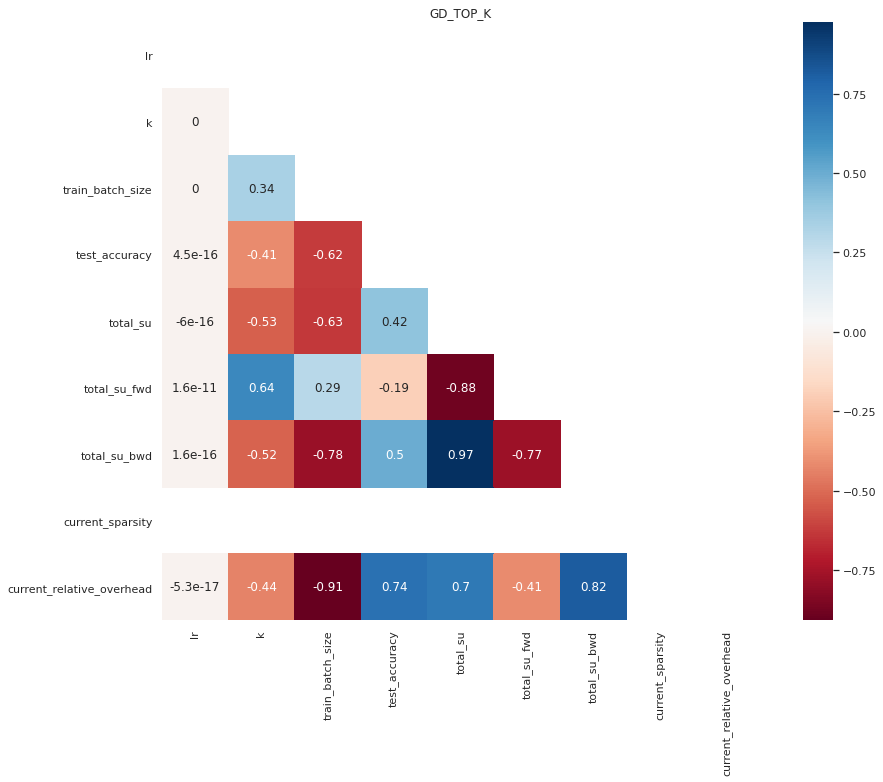

EXP.: gd_top_k_mc, MODEL: resnet18, DATA: cifar10
ACC.: 0.77, TRAIN SU: 1.1, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.72, TRAIN SU: 1.47, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 1.73, INF. SU: 1.0, SP.: 0.0





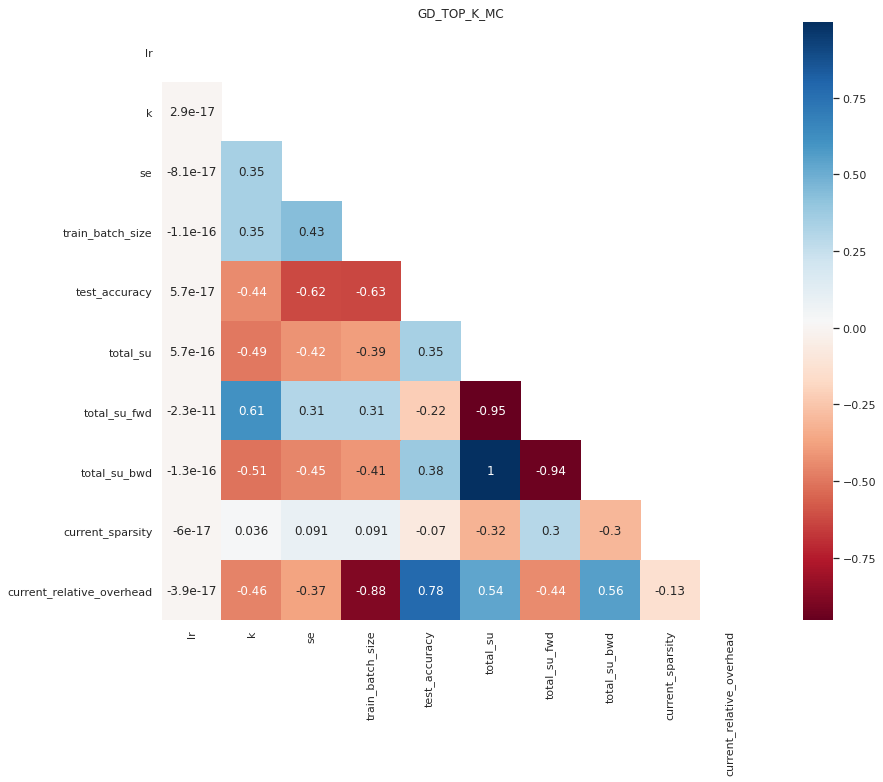

EXP.: gd_top_k_mc_ac, MODEL: resnet18, DATA: cifar10
ACC.: 0.77, TRAIN SU: 1.51, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.71, TRAIN SU: 1.83, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 2.32, INF. SU: 1.0, SP.: 0.0





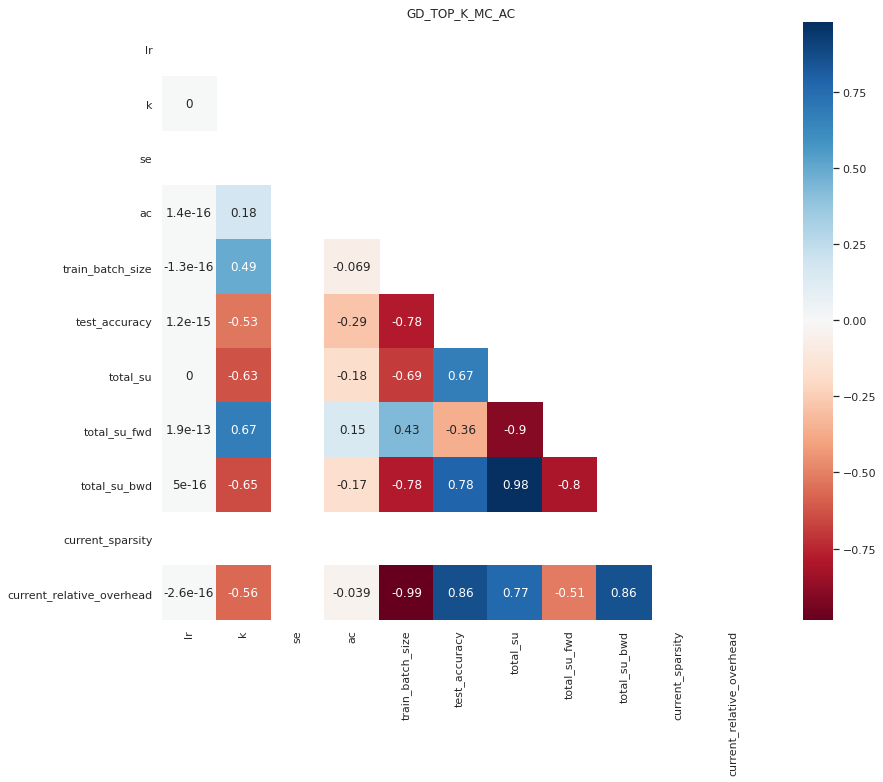

EXP.: gd_top_k_mc_ac_dk, MODEL: resnet18, DATA: cifar10
ACC.: 0.77, TRAIN SU: 1.46, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: resnet18, DATA: cifar100
ACC.: 0.42, TRAIN SU: 1.41, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.73, TRAIN SU: 1.5, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: alexnet_s, DATA: cifar100
ACC.: 0.37, TRAIN SU: 1.51, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 2.21, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: mobilenet_v2, DATA: cifar10
ACC.: 0.7, TRAIN SU: 1.42, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: mobilenet_v2, DATA: cifar100
ACC.: 0.32, TRAIN SU: 1.41, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: mobilenet_v3_s, DATA: cifar10
ACC.: 0.61, TRAIN SU: 1.37, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: mobilenet_v3_s, DATA: cifar100
ACC.: 0.29, TRAIN SU: 1.36, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_

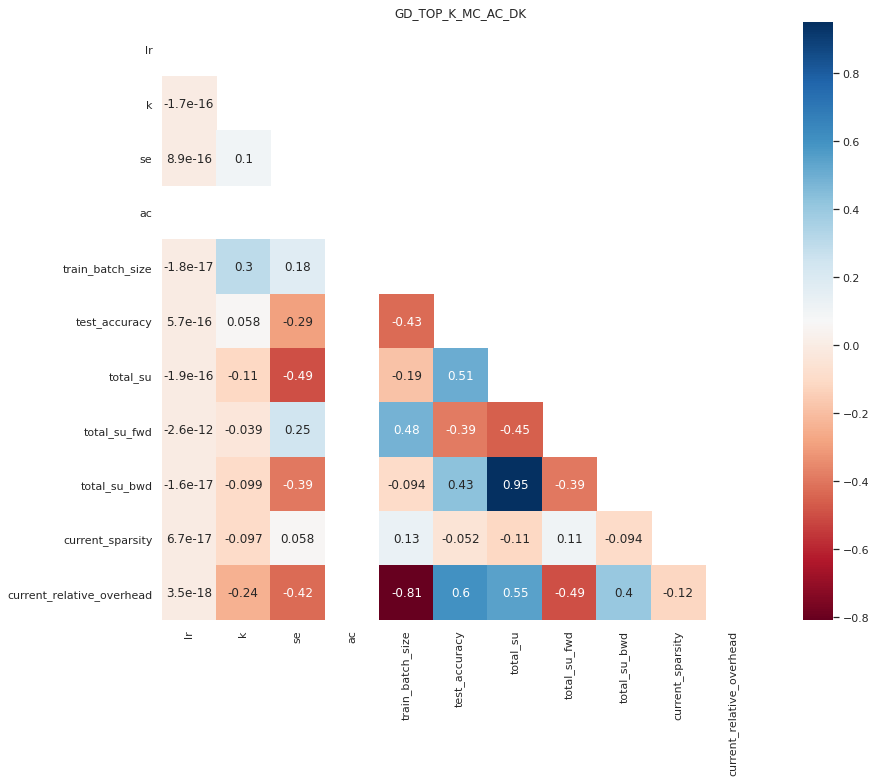

EXP.: gd_top_k_mc_ac_dk_admm_intra, MODEL: resnet18, DATA: cifar10
ACC.: 0.75, TRAIN SU: 3.01, INF. SU: 1.86, SP.: 0.71
EXP.: gd_top_k_mc_ac_dk_admm_intra, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.73, TRAIN SU: 2.69, INF. SU: 1.86, SP.: 0.98
EXP.: gd_top_k_mc_ac_dk_admm_intra, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 3.44, INF. SU: 3.28, SP.: 0.94





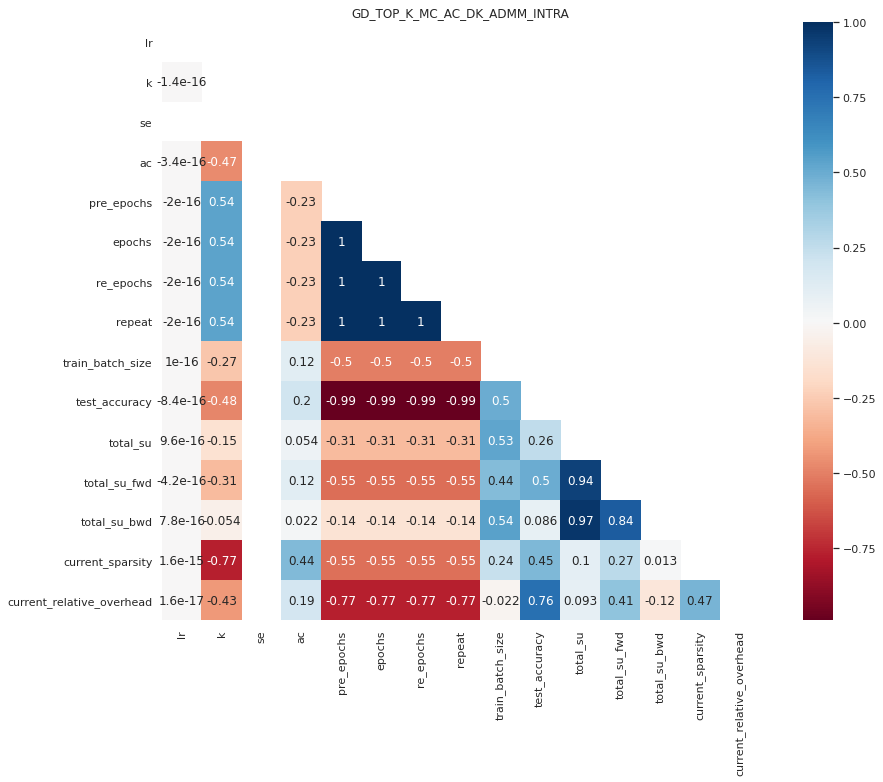

EXP.: gd_top_k_mc_ac_dk_admm_retrain, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 2.34, INF. SU: 12.01, SP.: 0.99





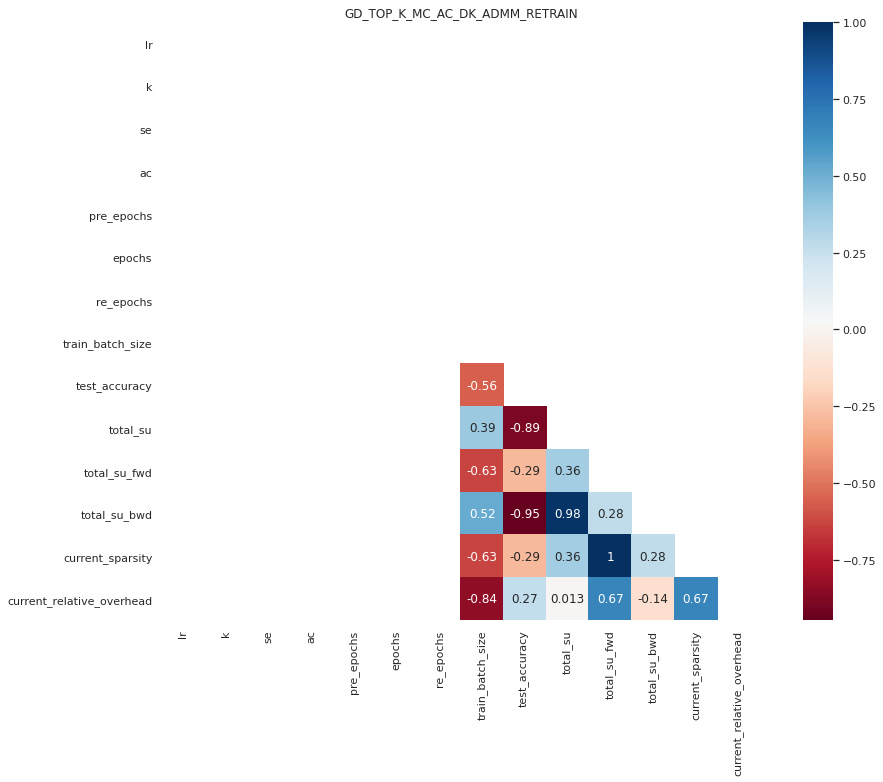

EXP.: re_pruning, MODEL: resnet18, DATA: cifar10
ACC.: 0.76, TRAIN SU: 1.22, INF. SU: 1.27, SP.: 0.96
EXP.: re_pruning, MODEL: resnet18, DATA: cifar100
ACC.: 0.42, TRAIN SU: 1.16, INF. SU: 1.19, SP.: 0.9
EXP.: re_pruning, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.69, TRAIN SU: 1.27, INF. SU: 1.33, SP.: 0.42
EXP.: re_pruning, MODEL: alexnet_s, DATA: cifar100
ACC.: 0.34, TRAIN SU: 1.35, INF. SU: 1.37, SP.: 0.24
EXP.: re_pruning, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 4.69, INF. SU: 4.05, SP.: 0.14
EXP.: re_pruning, MODEL: mobilenet_v2, DATA: cifar10
ACC.: 0.75, TRAIN SU: 1.19, INF. SU: 1.29, SP.: 0.79
EXP.: re_pruning, MODEL: mobilenet_v2, DATA: cifar100
ACC.: 0.36, TRAIN SU: 1.08, INF. SU: 1.09, SP.: 0.53
EXP.: re_pruning, MODEL: vgg8, DATA: cifar10
ACC.: 0.75, TRAIN SU: 1.23, INF. SU: 1.36, SP.: 0.91
EXP.: re_pruning, MODEL: vgg11, DATA: cifar10
ACC.: 0.7, TRAIN SU: 1.35, INF. SU: 1.41, SP.: 0.3





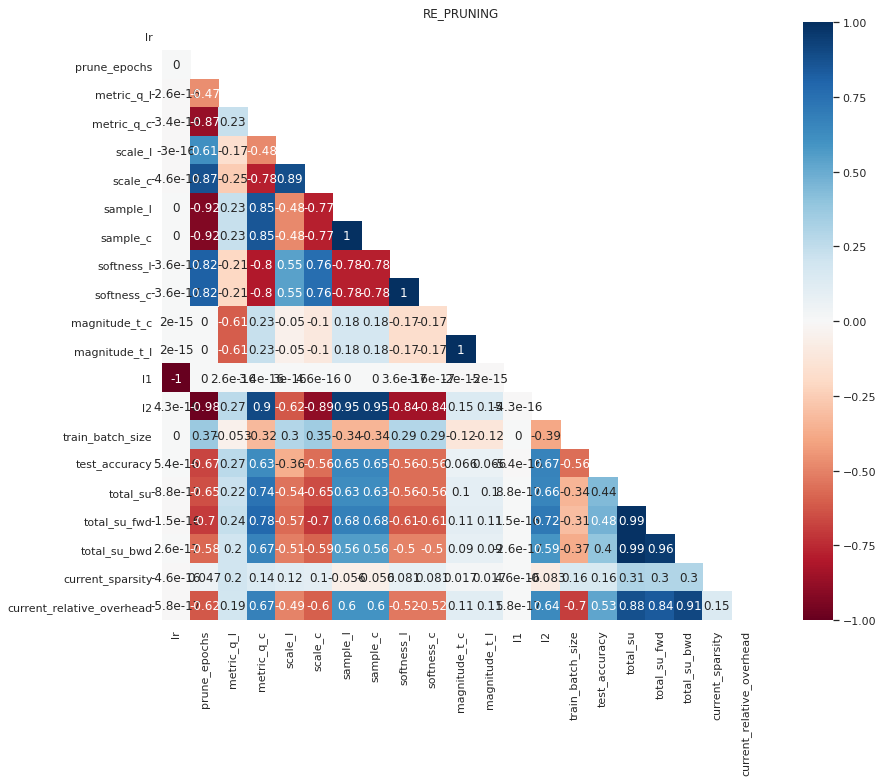

EXP.: re_pruning_ac, MODEL: resnet18, DATA: cifar10
ACC.: 0.75, TRAIN SU: 1.55, INF. SU: 1.2, SP.: 0.92
EXP.: re_pruning_ac, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.67, TRAIN SU: 1.89, INF. SU: 1.39, SP.: 0.2
EXP.: re_pruning_ac, MODEL: lenet, DATA: mnist
ACC.: 0.98, TRAIN SU: 31.33, INF. SU: 14.29, SP.: 0.99
EXP.: re_pruning_ac, MODEL: vgg8, DATA: cifar10
ACC.: 0.75, TRAIN SU: 1.62, INF. SU: 1.3, SP.: 0.91





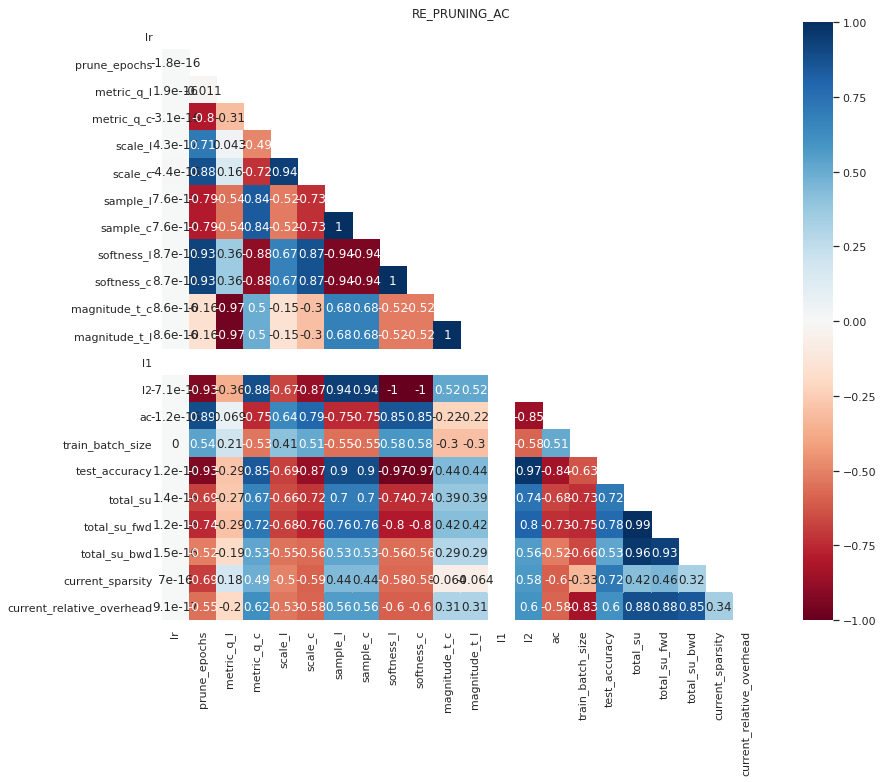

EXP.: re_pruning_admm_intra, MODEL: resnet18, DATA: cifar10
ACC.: 0.75, TRAIN SU: 2.45, INF. SU: 1.92, SP.: 0.9
EXP.: re_pruning_admm_intra, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.7, TRAIN SU: 2.58, INF. SU: 1.86, SP.: 0.99
EXP.: re_pruning_admm_intra, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 13.7, INF. SU: 12.02, SP.: 0.99





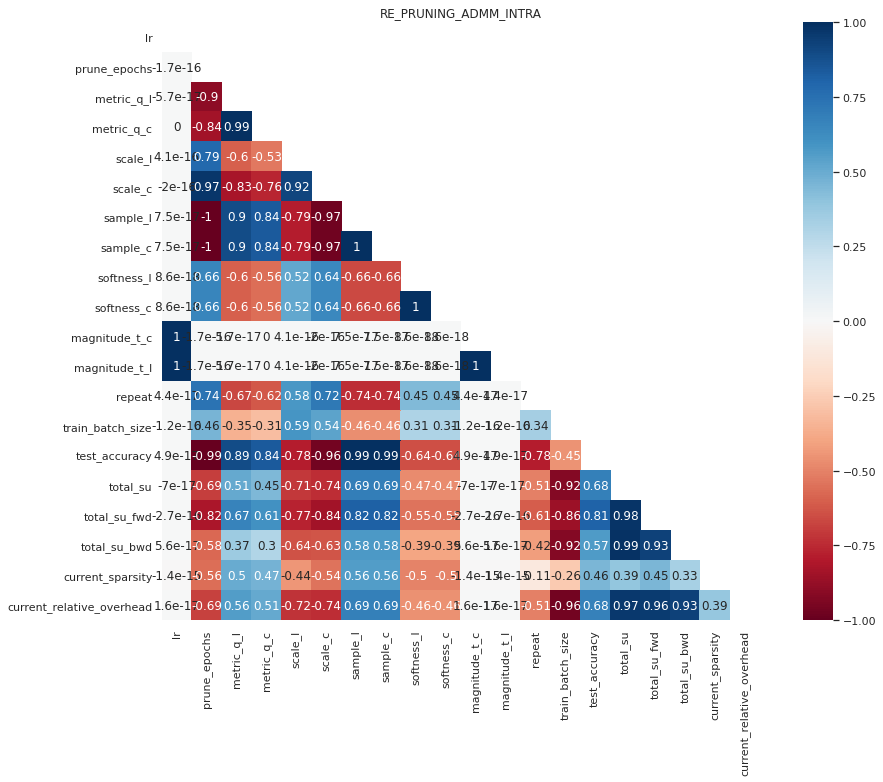

EXP.: re_pruning_admm_retrain, MODEL: resnet18, DATA: cifar10
ACC.: 0.7, TRAIN SU: 1.37, INF. SU: 1.91, SP.: 0.88
EXP.: re_pruning_admm_retrain, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.68, TRAIN SU: 2.27, INF. SU: 1.87, SP.: 0.99
EXP.: re_pruning_admm_retrain, MODEL: lenet, DATA: mnist
ACC.: 0.98, TRAIN SU: 13.83, INF. SU: 14.42, SP.: 0.99





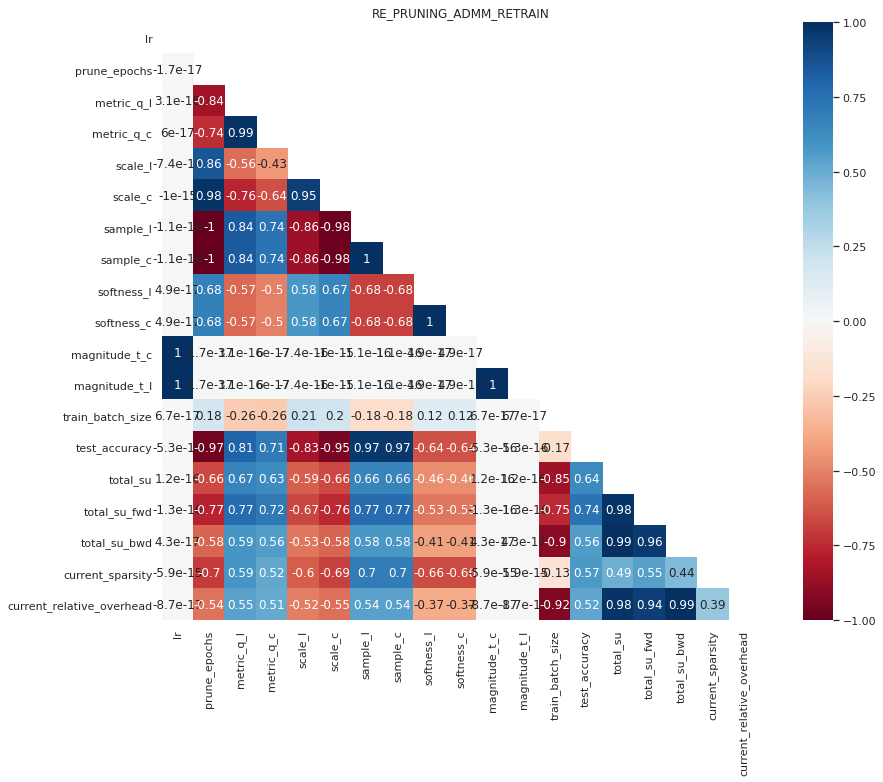

EXP.: re_pruning_ac_admm_intra, MODEL: resnet18, DATA: cifar10
ACC.: 0.75, TRAIN SU: 3.24, INF. SU: 1.9, SP.: 0.88
EXP.: re_pruning_ac_admm_intra, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.71, TRAIN SU: 2.77, INF. SU: 1.86, SP.: 0.98
EXP.: re_pruning_ac_admm_intra, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 11.77, INF. SU: 12.03, SP.: 0.99





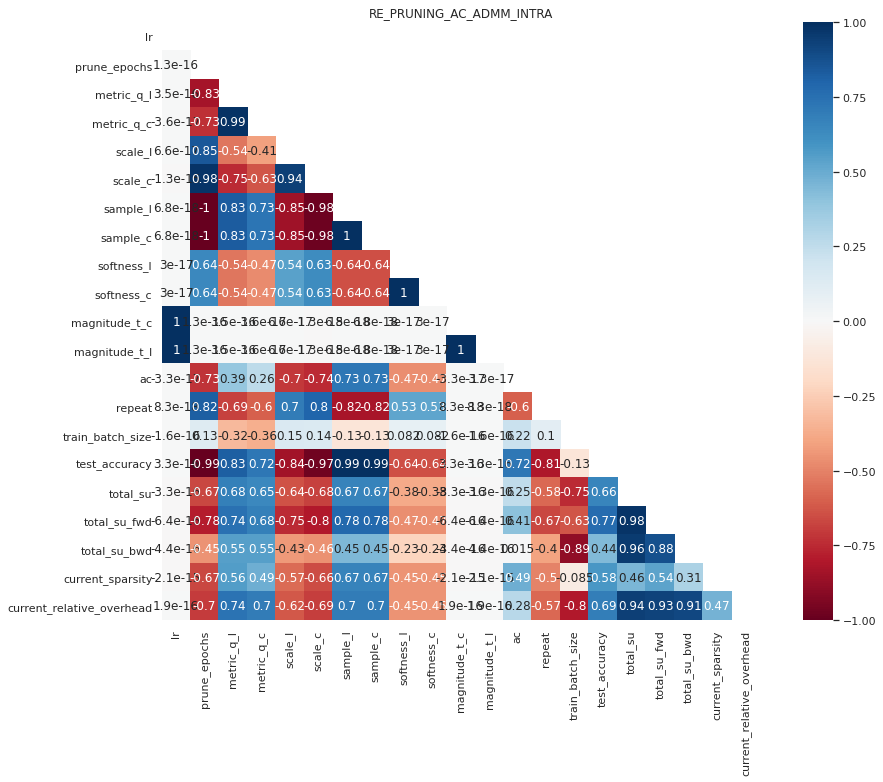

EXP.: re_pruning_ac_admm_retrain, MODEL: resnet18, DATA: cifar10
ACC.: 0.67, TRAIN SU: 1.83, INF. SU: 1.9, SP.: 0.87
EXP.: re_pruning_ac_admm_retrain, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.66, TRAIN SU: 2.53, INF. SU: 1.87, SP.: 0.99
EXP.: re_pruning_ac_admm_retrain, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 9.66, INF. SU: 12.02, SP.: 0.99





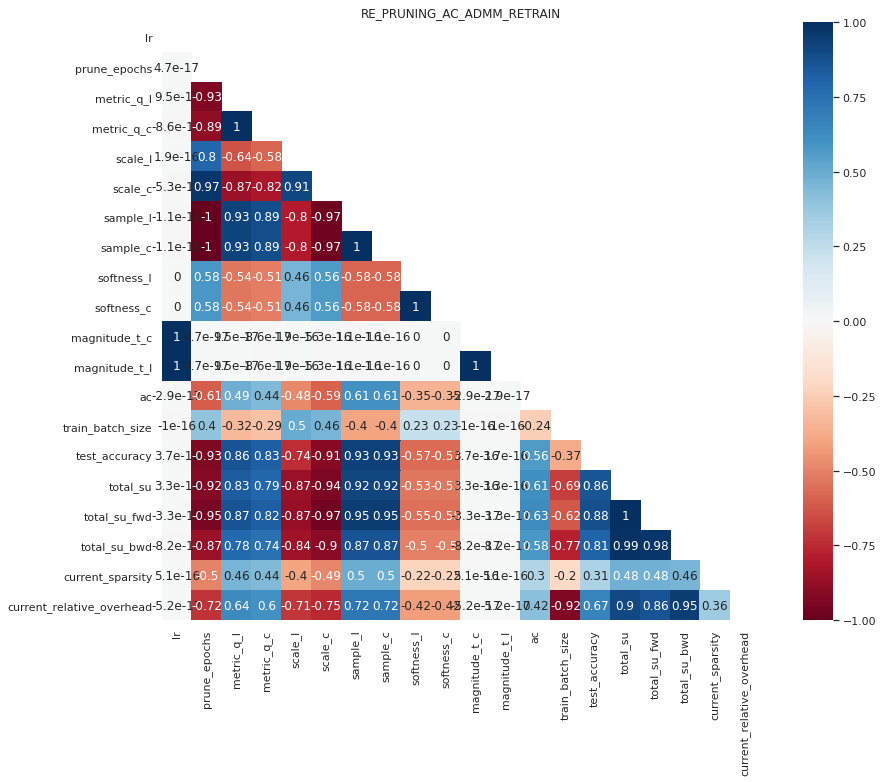

EXP.: re_pruning_gd_top_k_mc_ac_dk_admm_intra, MODEL: resnet18, DATA: cifar10
ACC.: 0.73, TRAIN SU: 3.2, INF. SU: 1.97, SP.: 0.91
EXP.: re_pruning_gd_top_k_mc_ac_dk_admm_intra, MODEL: resnet20, DATA: cifar10
ACC.: 0.73, TRAIN SU: 3.09, INF. SU: 1.9, SP.: 0.79
EXP.: re_pruning_gd_top_k_mc_ac_dk_admm_intra, MODEL: resnet50, DATA: cifar10
ACC.: 0.71, TRAIN SU: 3.35, INF. SU: 1.92, SP.: 0.81
EXP.: re_pruning_gd_top_k_mc_ac_dk_admm_intra, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.71, TRAIN SU: 2.87, INF. SU: 1.86, SP.: 0.98
EXP.: re_pruning_gd_top_k_mc_ac_dk_admm_intra, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 17.86, INF. SU: 12.09, SP.: 0.99
EXP.: re_pruning_gd_top_k_mc_ac_dk_admm_intra, MODEL: mobilenet_v2, DATA: cifar10
ACC.: 0.69, TRAIN SU: 2.08, INF. SU: 1.45, SP.: 0.46
EXP.: re_pruning_gd_top_k_mc_ac_dk_admm_intra, MODEL: mobilenet_v3_s, DATA: cifar10
ACC.: 0.61, TRAIN SU: 1.97, INF. SU: 1.43, SP.: 0.48





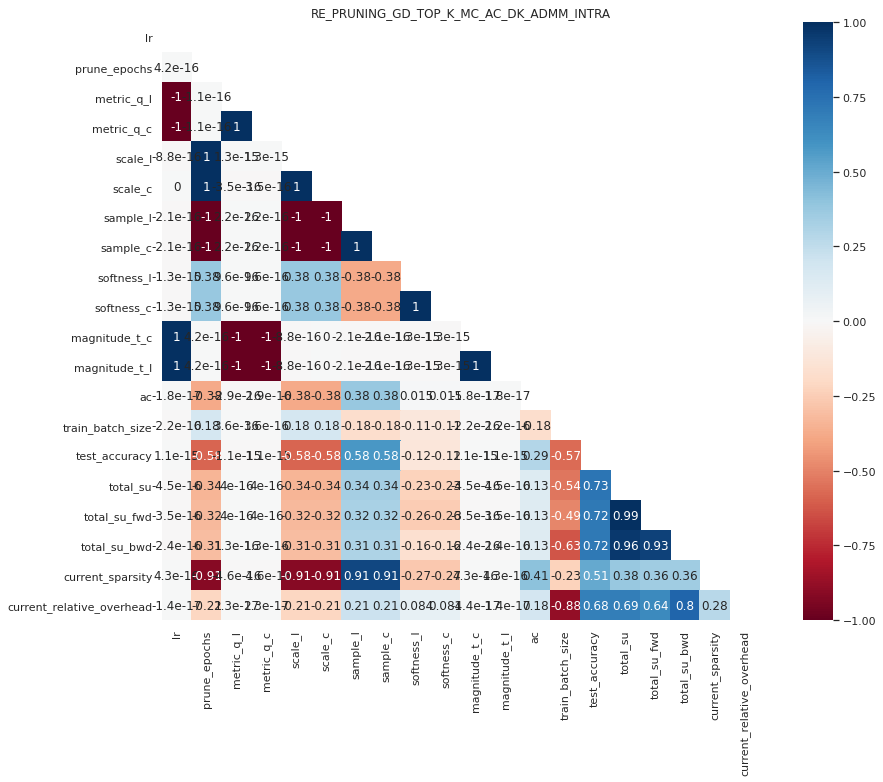

EXP.: re_pruning_gd_top_k_mc_ac_dk_admm_retrain, MODEL: resnet18, DATA: cifar10
ACC.: 0.7, TRAIN SU: 2.0, INF. SU: 1.98, SP.: 0.91
EXP.: re_pruning_gd_top_k_mc_ac_dk_admm_retrain, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.71, TRAIN SU: 3.25, INF. SU: 1.87, SP.: 0.99
EXP.: re_pruning_gd_top_k_mc_ac_dk_admm_retrain, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 4.63, INF. SU: 12.05, SP.: 0.99





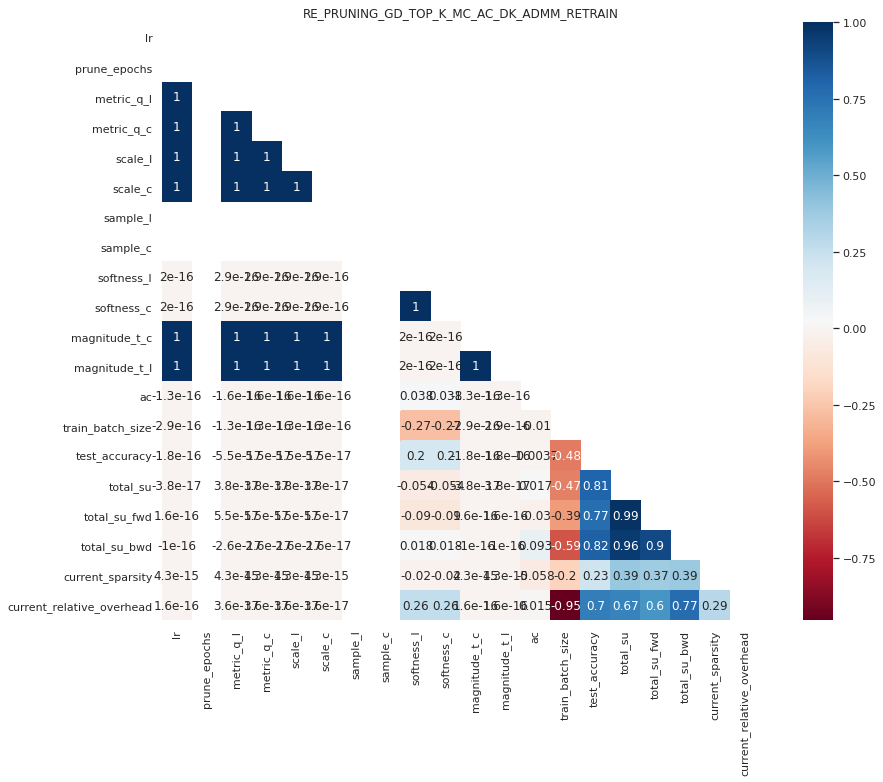

In [14]:
datasets = [
    'cifar10', 
    'cifar100', 
    'mnist',
    'imagenet_tiny',
    'imagenet_full',
]
models = [
    'resnet18', 
    'resnet20',
    'resnet32',
    'resnet34',
    'resnet50',
    'alexnet_s', 
    'alexnet',
    'lenet', 
    'mobilenet_v2', 
    'mobilenet_v3_s', 
    'vgg8',
    'vgg11', 
    'vgg13', 
    'vgg16'
         ]
best_results = {}
plt_corr = True
sns.set(rc={'figure.figsize':(1.33*11.7,1.33*8.27)})
sns.set_theme(style="white")


cross_eval(best_results, datasets, models, 'baseline', ['lr', 'epochs', 'train_batch_size'], ['test_accuracy'], plt_corr)


cross_eval(best_results, datasets, models, 'admm_intra', 
     ['lr', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'admm_retrain', 
     ['lr', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)

cross_eval(best_results, datasets, models, 'gd_top_k', ['lr', 'k', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'gd_top_k_mc', ['lr', 'k', 'se', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'gd_top_k_mc_ac', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'gd_top_k_mc_ac_dk', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'gd_top_k_mc_ac_dk_admm_intra', 
     ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'gd_top_k_mc_ac_dk_admm_retrain',  
     ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)


cross_eval(best_results, datasets, models, 're_pruning', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 're_pruning_ac', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 'ac', 
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)


cross_eval(best_results, datasets, models, 're_pruning_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'repeat',
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 're_pruning_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 're_pruning_ac_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 'repeat',
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 're_pruning_ac_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)



cross_eval(best_results, datasets, models, 're_pruning_gd_top_k_mc_ac_dk_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 
      'metric_q_c', 'scale_l', 'scale_c', 'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 
      'magnitude_t_l', 'ac', 'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 
      'total_su_bwd', 'current_sparsity', 'current_relative_overhead'], plt_corr)

cross_eval(best_results, datasets, models, 're_pruning_gd_top_k_mc_ac_dk_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 
      'metric_q_c', 'scale_l', 'scale_c', 'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 
      'magnitude_t_l', 'ac', 'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 
      'total_su_bwd', 'current_sparsity', 'current_relative_overhead'], plt_corr)

In [7]:
search_n, search_m, search_d = 're_pruning', 'mobilenet_v2', 'cifar10'
for name in best_results:
    if name == search_n:
        for model in best_results[name]['cfg']:
            if search_m == model:
                for data in best_results[name]['cfg'][model]:
                    if search_d == data:
                        if 'METADATA' in best_results[name]['cfg'][model][data]:
                            print(best_results[name]['cfg'][model][data]['METADATA'])
        #print(best_results[name]['cfg'])

{'EXPERIMENT': {'name': 're_pruning', 'model': 'mobilenet_v2', 'dataset': 'cifar10', 'train_batch_size': '256', 'test_batch_size': '1000'}, 'SPECIFICATION': {'lb': '45', 'num_classes': '10', 'epochs': '100', 'lr': '1e-1', 'l1': '1e-4', 'l2': '1e-8', 'steps': '50, 75', 'gamma': '0.1', 'softness_c': '0.9', 'magnitude_t_c': '1e-3', 'metric_q_c': '0.05', 'sample_c': '100', 'scale_c': '0.25', 'softness_l': '0.9', 'magnitude_t_l': '1e-3', 'metric_q_l': '0.001', 'sample_l': '100', 'scale_l': '0.25', 'prune_epochs': '2'}, 'OTHER': {'no_cuda': 'False', 'seed': '1', 'save_model': 'False', 'vis_model': 'False', 'vis_log': 'True', 'out_path': 'Default'}}


In [8]:
import collections

In [9]:
new_logdict = {}
for log in logs:
    for key in log['LOGDATA']:
        new_key = log['METADATA']['EXPERIMENT']['dataset'] + '+'
        new_key += log['METADATA']['EXPERIMENT']['name'] + '+'
        new_key += log['METADATA']['EXPERIMENT']['model']
        if log['LOGDATA']['test_accuracy'][-1] <= 0.1:
                continue
        if new_key not in new_logdict:
            new_logdict[new_key] = {}
        if key not in new_logdict[new_key]:
            new_logdict[new_key][key] = []
            
        if 'overhead' in key:
            #print(sum(log['LOGDATA'][key])/len(log['LOGDATA'][key]), flush=True)
            if ('_mc' in log['METADATA']['EXPERIMENT']['name'] and
                'gd' in log['METADATA']['EXPERIMENT']['name'] and not
                'admm' in log['METADATA']['EXPERIMENT']['name']):
                
                    idx = int((len(log['LOGDATA'][key])*
                           float(log['METADATA']['SPECIFICATION']['se'])/
                           float(log['METADATA']['SPECIFICATION']['epochs'])))+1
                    new_logdict[new_key][key].append(sum(log['LOGDATA'][key][:idx])/len(log['LOGDATA'][key]))
                    #print(log['METADATA']['EXPERIMENT']['name'], 
                    #      sum(log['LOGDATA'][key][:idx])/len(log['LOGDATA'][key]),
                    #      sum(log['LOGDATA'][key])/len(log['LOGDATA'][key]))
            else:
                new_logdict[new_key][key].append(sum(log['LOGDATA'][key])/len(log['LOGDATA'][key]))
        elif 'gradient' in key:
            new_logdict[new_key][key].append(sum(log['LOGDATA'][key])/len(log['LOGDATA'][key]))
        else:
            new_logdict[new_key][key].append(log['LOGDATA'][key][-1])
        
n = 15
for key in new_logdict:
    if not 'baseline' in key and '+mob' in key:#('+resnet' in key or '+alexnet' in key or '+lenet' in key):
        print(key)
        idx = sorted(range(len(new_logdict[key]['total_su'])), 
                     key=lambda i: new_logdict[key]['total_su'][i])[-n:]
        idx = idx[:3]
        idx.reverse()
        print('Acc, C/F, P, FLOPs(i), FLOPs(T), G')
        for i in idx:
            #print(new_logdict[key].keys()) #current_channel_sparsity', 'current_linear_sparsity #current_relative_overhead'
            print(round(new_logdict[key]['test_accuracy'][i],2), 
                  round(new_logdict[key]['current_channel_sparsity'][i],2),
                  round(new_logdict[key]['current_sparsity'][i],2),
                  round(1-1/new_logdict[key]['current_su_fwd'][i],2),
                  round(1-1/new_logdict[key]['total_su'][i],2),
                  round(new_logdict[key]['current_gradient_sparsity'][i],2),
                  #round(new_logdict[key]['current_relative_overhead'][i]*1e5, 2),
                  #round(1-1/new_logdict[key]['current_su_bwd'][i],2),
                  #round(new_logdict[key]['total_su'][i],2),
                  #round(new_logdict[key]['current_sparsity'][i],2))+
                  )
                  #round(new_logdict[key]['current_relative_overhead'][i],2))
        print('\n')
    #for subkey in new_logdict[key]:
    #    if not 'features' in subkey and not 'weight' in subkey:
            
            

cifar100+gd_top_k_mc_ac_dk+mobilenet_v2
Acc, C/F, P, FLOPs(i), FLOPs(T), G
0.32 0.0 0.0 0.0 0.29 0.0


cifar10+gd_top_k_mc_ac_dk+mobilenet_v2
Acc, C/F, P, FLOPs(i), FLOPs(T), G
0.7 0.0 0.0 0.0 0.3 0.0


cifar100+gd_top_k_mc_ac_dk+mobilenet_v3_s
Acc, C/F, P, FLOPs(i), FLOPs(T), G
0.29 0.0 0.0 0.0 0.26 0.04


cifar10+gd_top_k_mc_ac_dk+mobilenet_v3_s
Acc, C/F, P, FLOPs(i), FLOPs(T), G
0.61 0.0 0.0 0.0 0.27 0.03


cifar100+re_pruning+mobilenet_v2
Acc, C/F, P, FLOPs(i), FLOPs(T), G
0.36 0.54 0.53 0.08 0.08 0.01


cifar10+re_pruning+mobilenet_v2
Acc, C/F, P, FLOPs(i), FLOPs(T), G
0.75 0.79 0.79 0.23 0.16 0.01
0.44 0.5 0.5 0.08 0.07 0.25


cifar10+re_pruning_gd_top_k_mc_ac_dk_admm_intra+mobilenet_v2
Acc, C/F, P, FLOPs(i), FLOPs(T), G
0.62 0.68 0.68 0.46 0.61 0.68
0.67 0.45 0.45 0.31 0.52 0.56
0.69 0.46 0.46 0.31 0.52 0.57


cifar10+re_pruning_gd_top_k_mc_ac_dk_admm_intra+mobilenet_v3_s
Acc, C/F, P, FLOPs(i), FLOPs(T), G
0.61 0.53 0.48 0.3 0.49 0.53
0.59 0.52 0.47 0.3 0.48 0.54
0.59 0.51 0.47 

In [10]:
datasets = [
    'cifar10', 
    'cifar100', 
    'mnist',
    'imagenet'
]
models = [
    'resnet18', 
    'alexnet_s', 
    'lenet', 
    'mobilenet_v2', 
    'mobilenet_v3', 
    'vgg8',
    'vgg11', 
    'vgg13', 
    'vgg16'
         ]
plt_corr = False

for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 'baseline', ['lr', 'epochs', 'train_batch_size'], ['test_accuracy'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 'admm_intra', 
             ['lr', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'admm_retrain', 
             ['lr', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)

for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 'gd_top_k', ['lr', 'k', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc', ['lr', 'k', 'se', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac_dk', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac_dk_admm_intra', 
             ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac_dk_admm_retrain',  
             ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 're_pruning', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_ac', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 'ac', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 're_pruning_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'repeat',
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_ac_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 'repeat',
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_ac_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 're_pruning_gd_top_k_mc_ac_dk_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 
              'metric_q_c', 'scale_l', 'scale_c', 'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 
              'magnitude_t_l', 'l1', 'l2', 'ac', 'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 
              'total_su_bwd', 'current_sparsity', 'current_relative_overhead'], False)

RESNET18 CIFAR10 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.75


RESNET18 CIFAR10 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.75


RESNET18 CIFAR100 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.43


RESNET18 CIFAR100 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.43


RESNET18 CIFAR100 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.43


ALEXNET_S CIFAR10 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.74


ALEXNET_S CIFAR10 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.74


ALEXNET_S CIFAR100 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.37


ALEXNET_S CIFAR100 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.41


LENET MNIST BASELINE
lr:1e-1
epochs:10
train_batch_size:256
test_accuracy:0.99


LENET MNIST BASELINE
lr:1e-1
epochs:10
train_batch_size:256
test_accuracy:0.99


MOBILENET_V2 CIFAR10 BASELINE
lr:1e-1
epochs:1


VGG8 CIFAR10 RE_PRUNING
lr:1e-1
prune_epochs:2
metric_q_l:0.001
metric_q_c:0.05
scale_l:0.25
scale_c:0.25
sample_l:300
sample_c:300
softness_l:0.9
softness_c:0.9
magnitude_t_c:1e-4
magnitude_t_l:1e-4
l1:1e-4
l2:1e-8
train_batch_size:256
test_accuracy:0.1
total_su:1.95
total_su_fwd:1.94
total_su_bwd:1.96
current_sparsity:1.0
current_relative_overhead:0.0


VGG8 CIFAR10 RE_PRUNING
lr:1e-1
prune_epochs:2
metric_q_l:0.001
metric_q_c:0.05
scale_l:0.25
scale_c:0.25
sample_l:100
sample_c:100
softness_l:0.9
softness_c:0.9
magnitude_t_c:1e-3
magnitude_t_l:1e-3
l1:1e-4
l2:1e-8
train_batch_size:256
test_accuracy:0.1
total_su:1.29
total_su_fwd:1.25
total_su_bwd:1.31
current_sparsity:1.0
current_relative_overhead:0.0


VGG8 CIFAR10 RE_PRUNING
lr:1e-1
prune_epochs:2
metric_q_l:0.001
metric_q_c:0.05
scale_l:0.25
scale_c:0.25
sample_l:100
sample_c:100
softness_l:0.9
softness_c:0.9
magnitude_t_c:1e-3
magnitude_t_l:1e-3
l1:1e-4
l2:1e-8
train_batch_size:256
test_accuracy:0.1
total_su:1.95
total_su_fwd:1

ValueError: could not convert string to float: 'False'